## Imports

In [2]:
import matplotlib.pyplot as plt

import shapely.geometry as geom
import shapely.affinity as aff
from shapely.ops import polygonize, unary_union

import math

## Generating a regular polygon

In [3]:
def makePoly(sides, radius):
    line = geom.LineString([(0, 0), (0, radius)])
    vertices = []

    if sides % 2 == 0:
        line = aff.rotate(line, -360 / sides / 2, origin=(0, 0))

    for i in range(0, sides):
        line = geom.LineString([*line.coords])
        vertices.append(line.coords[1])
        line = aff.rotate(line, -360 / sides, origin=(0, 0))

    return geom.Polygon(vertices)

## Miscellaneous and small functions

In [4]:
def touches(point, poly):
    return point.distance(geom.LineString(poly.exterior.coords)) < 0.00000000001

def extractPoint(index, poly):
    return geom.Point(poly.exterior.coords[index])

def changePoint(index, poly, direction):
    if index == 0 and direction == -1:
        return len(poly.exterior.coords) - 2
    elif index == len(poly.exterior.coords) - 2 and direction == 1:
        return 0
    else:
        return index + direction

## Finding and rotating by the angle needed for rolling

In [5]:
def angleFinder(a, b, nextA, nextB, tracingPoint, result, accuracy):
    aAngle = (len(a.exterior.coords) - 3) * 180 / (len(a.exterior.coords) - 1)
    if touches(nextA[0], b):
        if nextB[0].__eq__(nextA[0]):
            # on edge
            angle = 360 - aAngle - bAngle
            nextB[1] = changePoint(nextB[1], b, -1)
        else:
            # over edge
            angle = 180 - aAngle
        rotationPoint = (nextA[0].x, nextA[0].y)
        nextA[1] = changePoint(nextA[1], a, 1)
    else:
        # behind edge
        bAngle = (len(b.exterior.coords) - 3) * 180 / (len(b.exterior.coords) - 1)
        angle = 180 - bAngle
        rotationPoint = (nextB[0].x, nextB[0].y)
        nextB[1] = changePoint(nextB[1], b, -1)

    b, tracingPoint, result = animRotate(b, angle, rotationPoint, tracingPoint, result, accuracy)
    nextA[0] = extractPoint(nextA[1], a)
    nextB[0] = extractPoint(nextB[1], b)
    
    return b, nextA, nextB, tracingPoint, result

# Creating the resultant path

In [6]:
def animRotate(poly, angle, rotationPoint, tracingPoint, result, accuracy):
    if accuracy > angle:
        iterations = -1
        angleLeftOver = angle
    else:
        iterations = int(angle // accuracy)
        angleLeftOver = angle - accuracy * iterations

    # angle is negative for clockwise, accuracy is the number of degrees between recording position
    for i in range(iterations):
        poly = aff.rotate(poly, -accuracy, origin=rotationPoint)
        tracingPoint = aff.rotate(tracingPoint, -accuracy, origin=rotationPoint)
        result.append(*tracingPoint.coords)

    poly = aff.rotate(poly, -angleLeftOver, origin=rotationPoint)
    tracingPoint = aff.rotate(tracingPoint, -angleLeftOver, origin=rotationPoint)
    if angleLeftOver > 0:
        result.append(*tracingPoint.coords)

    return poly, tracingPoint, result

## Plotting geometries

In [7]:
def plotCoords(coords, axes):
    x,y = zip(*list(coords))
    axes.plot(x,y)

def plotPoints(points, axes):
    x,y = zip(*list(points))
    axes.scatter(x, y)

def plotPolys(polys, axes):
    for poly in polys:
        if not getattr(poly, "exterior", None):
            print("got line?")

        plotCoords(poly.exterior.coords, axes)

        for hole in poly.interiors:
            plotCoords(hole.coords, axes)

## Initial rotation

In [8]:
def rotation(b, accuracy, animation=True):
    a = makePoly(5, 1)
    b = aff.translate(b, yoff=abs(a.bounds[3]) + abs(b.bounds[1]))
    tracingPoint = geom.Point(b.centroid.coords[0][0], b.bounds[1])
    result = [*tracingPoint.coords]

    nextA = [extractPoint((len(a.exterior.coords) - 2) // 2, a), (len(a.exterior.coords) - 2) // 2]
    nextB = [extractPoint((len(b.exterior.coords) - 2) // 2, b), (len(b.exterior.coords) - 2) // 2]

    aAngle = (len(a.exterior.coords) - 3) * 180 / (len(a.exterior.coords) - 1)
    if (len(a.exterior.coords) - 1) % 2 == 1:
        # special case
        angle = (180 - aAngle) / 2
        rotationPoint = a.exterior.coords[0]
        nextA[1] = 1
    elif touches(extractPoint(0, a), b):
        if nextB[0].__eq__(nextA[0]):
            # on edge
            angle = 360 - aAngle - bAngle
            nextB[1] = (nextB[1] - 1) % len(b.exterior.coords)
        else:
            # over edge
            angle = 180 - aAngle
        rotationPoint = a.exterior.coords[0]
        nextA[1] = 1
    else:
        # behind edge
        bAngle = (len(b.exterior.coords) - 3) * 180 / (len(b.exterior.coords) - 1)
        angle = 180 - bAngle
        rotationPoint = (nextB[0].x, nextB[0].y)
        nextA[1] = 0

    b, tracingPoint, result = animRotate(b, angle, rotationPoint, tracingPoint, result, accuracy)
    nextA[0] = extractPoint(nextA[1], a)
    nextB[0] = extractPoint(nextB[1], b)

    # rotate until result can be made into a
    for i in range(2):
        b, nextA, nextB, tracingPoint, result = angleFinder(a, b, nextA, nextB, tracingPoint, result, accuracy)
    # rotate until result is complex
    while geom.LineString(result).is_simple:
        b, nextA, nextB, tracingPoint, result = angleFinder(a, b, nextA, nextB, tracingPoint, result, accuracy)

    result = geom.LineString(result)
    result = polygonize(unary_union(result))
    copy = result[0]

    for index, val in enumerate(result, 1):
        if math.sqrt((val.bounds[2] - val.bounds[0])**2 + (val.bounds[3] - val.bounds[1])**2) > math.sqrt((copy.bounds[2] - copy.bounds[0])**2 + (copy.bounds[3] - copy.bounds[1])**2):
            copy = val
    result = copy

    return [b.length, result.length, a, b, result]

# Animation

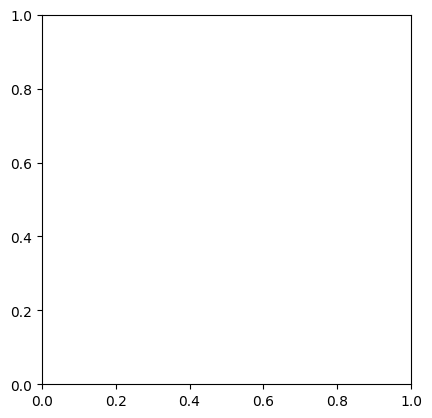

In [9]:
fig, ax = plt.subplots()
ax.axes.set_aspect("equal")

b = makePoly(3, 2)
result = rotation(b, 3, animation=True)

# Thing

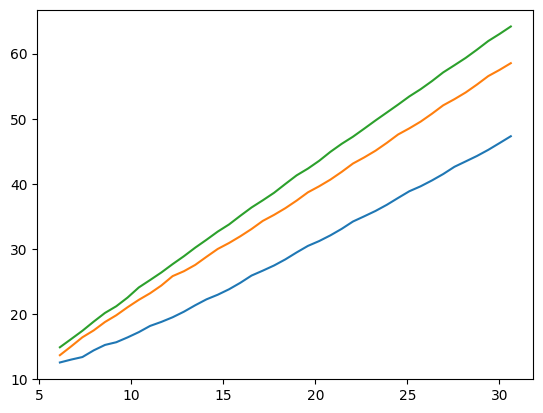

In [13]:
x_data = []
y_data = [[], [], []]
i = 1
while i <= 5:
    try:
        result = rotation(makePoly(3, i), 1)
        x_data.append(result[0])
        y_data[0].append(result[1])

        result = rotation(makePoly(5, i), 3)
        y_data[1].append(result[1])

        result = rotation(makePoly(8, i), 3)
        y_data[2].append(result[1])
    except IndexError:
        print(i)

    i += 0.1

fig, ax = plt.subplots()
ax.plot(x_data, y_data[0])
ax.plot(x_data, y_data[1])
ax.plot(x_data, y_data[2])

29.61806880942806


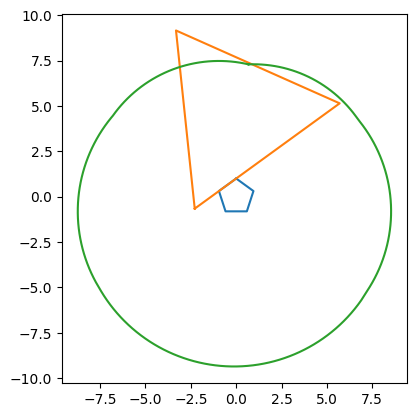

In [11]:
fig, ax = plt.subplots()
ax.axes.set_aspect("equal")

b = makePoly(3, 5.7)
result = rotation(b, 1)
plotPolys([result[2], result[3], result[4]], ax)
print(result[0])

# Pictures

## Result

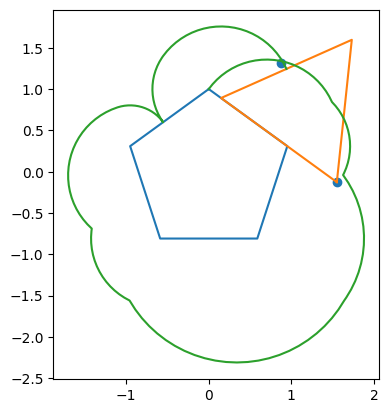 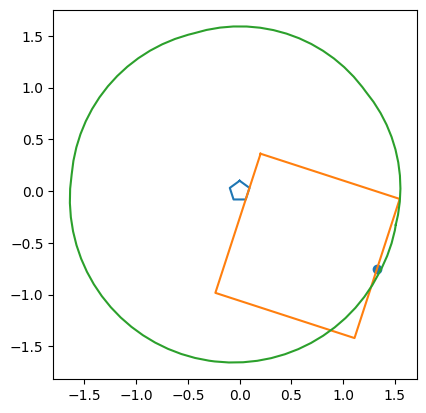 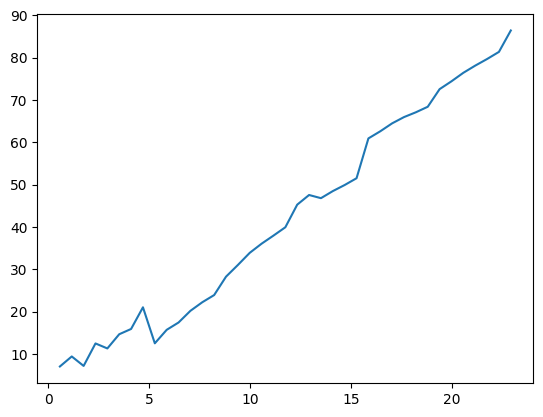

## States after rotation

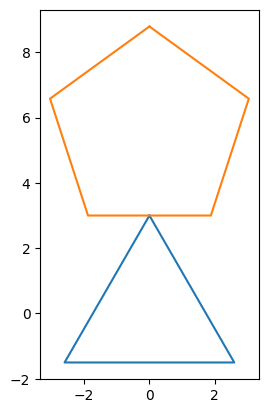 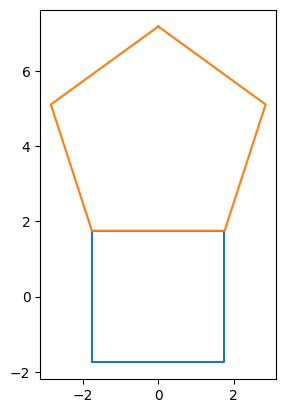 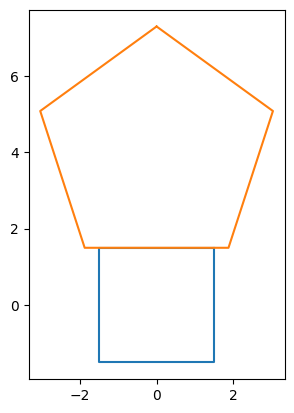 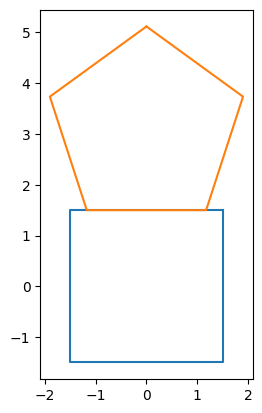